# Link Volumes Visualization

Visualize link volumes using Geopandas.

## Setup
First define some constants containing paths on your own filesystem.

In [1]:
# When using a ziped release:
import os
#CLASSPATH = os.pathsep.join(('path/to/matsim-0.10.1/matsim-0.10.1.jar', 'path/to/matsim-0.10.1/lib/*'))

CLASSPATH = r'path/to/abmt-2018-0.0.1-SNAPSHOT-jar-with-dependencies_jdeqsim.jar'
OUTPUT_PATH = r'path/to/output/'

# Those constants should not need modification:
NETWORK_FILE = OUTPUT_PATH + 'output_network.xml.gz'
EVENTS_FILE = OUTPUT_PATH + 'output_events.xml.gz'

Standard python imports.

For this notebook, you will need [JPype](https://jpype.readthedocs.io/en/latest/), a Python library that allows to use Java classes directly.
With anaconda, this can be done by running the following command in the "anaconda prompt":

```
conda install -c conda-forge jpype1
```

Spatial analysis will be done using `geopandas`, which can be installed the usual way.

In [91]:
import jpype as jp
import jpype.imports as jimport
from shutil import rmtree
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
#import mplleaflet
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

Java connection magic:
1. register the "org" domain, to have access to all
"org.some.thing" java packages
   as if they were python packages.
2. start the
java virtual machine, with MATSim on the classpath (the path were
   libraries
are searched for)

In [3]:
jimport.registerDomain('org')
jp.startJVM(jp.getDefaultJVMPath(), '-Djava.class.path=%s' % CLASSPATH,  '-Xmx1g')


Now we can import any MATSim class as if they were python:

In [4]:
from org.matsim.core.scenario import ScenarioUtils
from org.matsim.core.config import ConfigUtils
from org.matsim.api.core.v01 import Id
from org.matsim.core.controler import Controler
from org.matsim.core.controler.OutputDirectoryHierarchy import OverwriteFileSetting
from org.matsim.api.core.v01.events.handler import LinkEnterEventHandler, LinkLeaveEventHandler, VehicleEntersTrafficEventHandler, VehicleLeavesTrafficEventHandler
from org.matsim.core.events import EventsUtils, MatsimEventsReader

##  Setup Scenario

Create a MATSim Scenario and load the network.
Note that code completion for java classes does not work very well: it is a good idea to still have a Java IDE open on the side.

In [12]:
config = ConfigUtils.createConfig()

# Set input files in the config object
config.network().setInputFile(NETWORK_FILE)

scenario = ScenarioUtils.loadScenario(config)

## Network

We transform the MATSim network to a GeoPandas data frame and
display it.

In [13]:
def to_frame(network, crs):
    def to_lines(network):
        for link in network.getLinks().values():
            start_coord = link.getFromNode().getCoord()
            end_coord = link.getToNode().getCoord()
            # TODO add Id
            yield {
                'id': link.getId().toString(),
                'length': link.getLength(),
                'geometry': LineString([(start_coord.getX(), start_coord.getY()), (end_coord.getX(), end_coord.getY())])
            }

    network_frame = gpd.GeoDataFrame.from_records(list(to_lines(network)))
    network_frame.crs = {'init': crs}
    return network_frame

network_frame = to_frame(scenario.getNetwork(), 'epsg:2154')

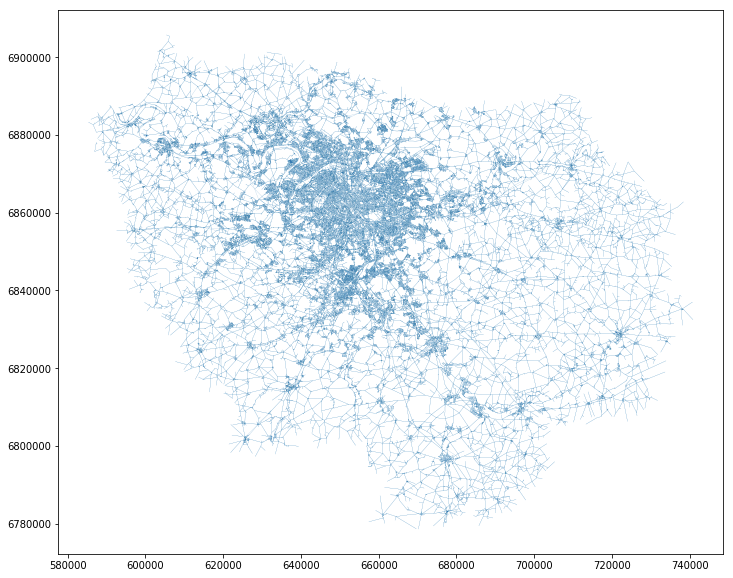

In [93]:
ax = network_frame.plot(linewidth=0.1)

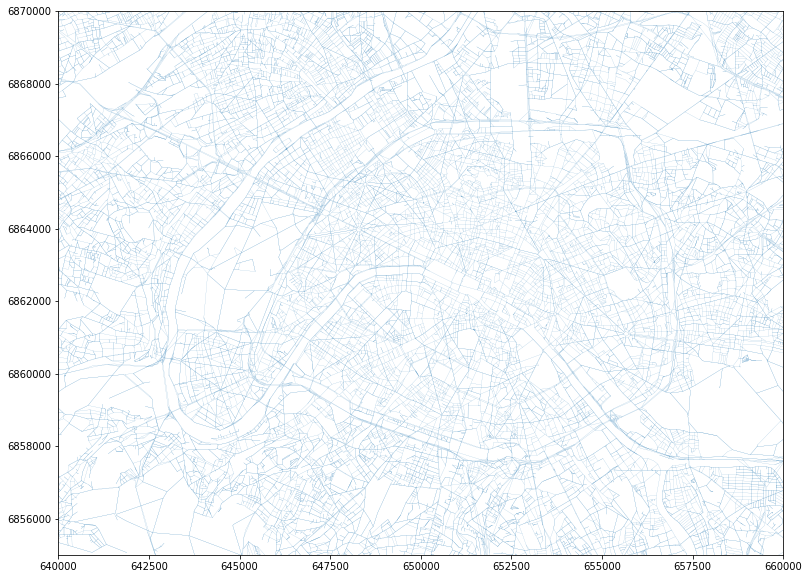

In [94]:
ax.set_xlim(640000,660000)
ax.set_ylim(6855000,6870000)
ax.figure

`mplleaflet` allows to have a zoomable map with a background, but does not
render in the static version (eg. on Github):

In [11]:
#mplleaflet.display(fig=ax.figure, crs=network_frame.crs, tiles='esri_natgeo')

## Event Handler

We create an handler that collects time-binned link volumes in
a data frame.

In [56]:
class VolumeHandler:
    ####################################################################
    # Methods for the python side
    ####################################################################
    def __init__(self, start_h, end_h):
        self.volumes = {}
        self.start = start_h * 3600
        self.end = end_h * 3600

    def get_volumes(self):
        volumes = pd.DataFrame.from_records([(k,v) for k, v in self.volumes.items()], columns=('link','volume'))
        volumes = network_frame.merge(volumes, how='outer', left_on='id', right_on='link')
        volumes.volume = volumes.volume.fillna(0)
        return volumes
        
    ####################################################################
    # Methods for the java side
    ####################################################################
        
    def handleEvent(self, event):
        time = event.getTime()
        if (time < self.start or time > self.end):
            return

        link = event.getLinkId().toString()
        if link in self.volumes:
            self.volumes[link] += 1
        else:
            self.volumes[link] = 1
        
    def reset(self, iteration):
        pass
    
    # JProxy does not provide default implementation for those methods:
    # provide one, to avoid crashes.
    # In true python way, the JProxy checks if a method exists only if actually
    # invoked.
    def hashCode(self):
        return 42
    
    def toString(self):
        return "%s" % self

handler = VolumeHandler(8,10)
handlerProxy = jp.JProxy((LinkLeaveEventHandler, LinkEnterEventHandler, VehicleEntersTrafficEventHandler, VehicleLeavesTrafficEventHandler), inst=handler)

## Parse Events

In [48]:
events = EventsUtils.createEventsManager()

events.addHandler(handlerProxy)

MatsimEventsReader(events).readFile(EVENTS_FILE)

## Analysis

In [50]:
volumes = handler.get_volumes()

In [71]:
volumes.query('volume > 0').volume.describe()

count    100514.000000
mean         15.183009
std          25.828053
min           1.000000
25%           2.000000
50%           6.000000
75%          16.000000
max         416.000000
Name: volume, dtype: float64

/home/thibautd/Documents/code/matsim-python-experiments/venv/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(6857000, 6868000)

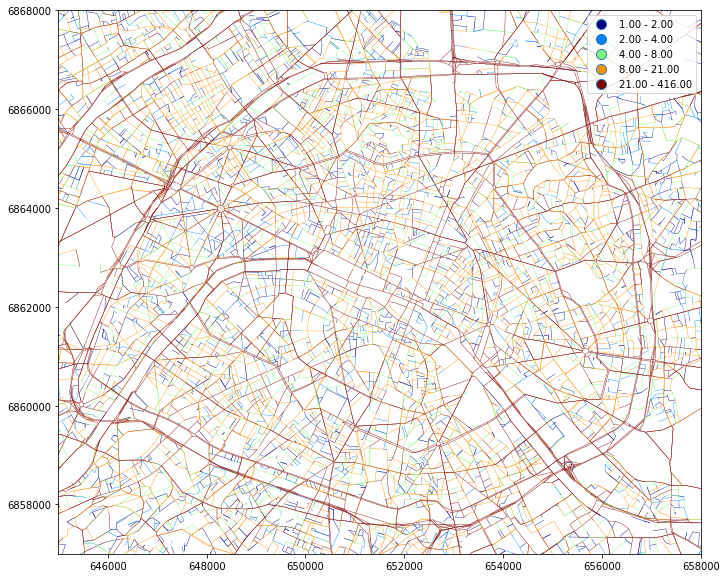

In [92]:
ax = volumes.query('volume > 0').plot(column='volume', scheme='quantiles', cmap='jet', linewidth=0.4, legend=True)
ax.set_xlim(645000,658000)
ax.set_ylim(6857000,6868000)